In [1]:
%install_ext http://raw.github.com/jrjohansson/version_information/master/version_information.py
%load_ext version_information
%reload_ext version_information
%version_information numpy, scipy, matplotlib, pandas

/home/ubuntu/anaconda2/lib/python2.7/site-packages/IPython/core/magics/extension.py:47: UserWarning: %install_ext` is deprecated, please distribute your extension as a python package.
  "as a python package.", UserWarning)


Installed version_information.py. To use it, type:
  %load_ext version_information


Software versions
Python 2.7.11 64bit [GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
IPython 4.1.2
OS Linux 3.13.0 74 generic x86_64 with debian jessie sid
numpy 1.10.4
scipy 0.17.0
matplotlib 1.5.1
pandas 0.18.0
Thu Jun 09 00:53:45 2016 UTC

In [2]:
# Couldn't find what to do with 'magic' imports at the top

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina' 

# Add this to python2 code to make life easier
from __future__ import absolute_import, division, print_function

from itertools import combinations
import string

from IPython.display import IFrame, HTML, YouTubeVideo
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns

sns.set();
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style("darkgrid")
sns.set_context("poster", font_scale=1.3)

In [3]:
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from nltk import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.ensemble import RandomForestClassifier

In [4]:
from feature_union import feature_union, DenseTransformer

In [5]:
# talk to postgresql
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
import pandas as pd

In [6]:
dbname = 'stackoverflow'
username = 'jojo'
pswd = 'iAmPass'

con = None
con = psycopg2.connect(database = dbname, user = username, host='localhost', password=pswd)

# Posts

- Id
- PostTypeId (listed in the PostTypes table)
  - Question (1)
  - Answer (2)
  - Orphaned tag wiki
  - Tag wiki excerpt
  - Tag wiki
  - Moderator nomination
  - "Wiki placeholder" (seems to only be the election description)
  - Privilege wiki
- AcceptedAnswerId (only present if PostTypeId is 1)
- ParentID (only present if PostTypeId is 2)
- CreationDate
- DeletionDate (only non-null for the SEDE PostsWithDeleted table. Deleted posts are not present on Posts. Column not present on data dump.)
- Score
- ViewCount (nullable)
- Body (as rendered HTML, not Markdown)
- OwnerUserId (only present if user has not been deleted; always -1 for tag wiki entries, i.e. the community user owns them)
- OwnerDisplayName (nullable)
- LastEditorUserId (nullable)
- LastEditorDisplayName (nullable)
- LastEditDate="2009-03-05T22:28:34.823" - the date and time of the most recent edit to the post (nullable)
- LastActivityDate="2009-03-11T12:51:01.480" - the date and time of the most recent activity on the post. For a question, this could be the post being edited, a new answer was posted, a bounty was started, etc.
- Title (nullable)
- Tags (nullable)
- AnswerCount (nullable)
- CommentCount
- FavoriteCount
- ClosedDate (present only if the post is closed)
- CommunityOwnedDate (present only if post is community wikied)

## Clean the Posts
1. Remove the records that are neighther questions nor answers

## Starting with subsection of the whole set

In [7]:
starting_date = '2016-02-06'
print("Consider data after {}".format(starting_date))

Consider data after 2016-02-06


In [8]:
# query:
sql_query = """
SELECT id, acceptedanswerid, creationdate, body, tags, title FROM posts 
where (posttypeid = 1) and creationdate > '{starting_date}'
;
""".format(starting_date=starting_date)
questions = pd.read_sql_query(sql_query, con)

In [9]:
questions.shape

(238685, 6)

In [10]:
questions.head()

,id,acceptedanswerid,creationdate,body,tags,title
0,35235548,NaN,2016-02-06 00:00:06.423,<p>I wrote javascript codes to animate side me...,<javascript><jquery><cookies><execution><clear...,how can I run $.cookie() after or before using...
1,35235551,35236820.0,2016-02-06 00:00:32.263,"<p>I have a MEAN.js application, and I'm tryin...",<angularjs><express><mean-stack><meanjs>,How to call an Express function from my Angula...
2,35235554,NaN,2016-02-06 00:00:48.947,<p>I have a small programm doing things with a...,<vb.net><powerpoint><shape><blinking>,How to make a shape blinking while msgbox is d...
3,35235557,NaN,2016-02-06 00:01:00.097,<p>This is just part of the question. It has e...,<python><tuples>,python take two integer arguments from a tuple
4,35235561,NaN,2016-02-06 00:01:34.097,<p>I am stuck trying to work this out. I cann...,<html><css>,Specify pixel density for responsive image


In [11]:
answered_q = questions[~questions.acceptedanswerid.isnull()]
print("{} out of {} questions get accepted answers".format(answered_q.shape[0], questions.shape[0]))

78027 out of 238685 questions get accepted answers


In [12]:
sql_query = """
SELECT id, creationdate, body FROM posts 
where (posttypeid = 2) and creationdate > '{starting_date}'
;
""".format(starting_date=starting_date)
answers = pd.read_sql_query(sql_query, con)

In [13]:
answers.head()

,id,creationdate,body
0,35235546,2016-02-06 00:00:04.940,<p>This is because <code>autofocus</code> is <...
1,35235547,2016-02-06 00:00:04.967,<pre><code>int flt32_abs (int x) {\n^^^ ...
2,35235549,2016-02-06 00:00:10.447,<p>The problem is the rewrite rule in your <co...
3,35235550,2016-02-06 00:00:17.983,<p>Initially we have to redefine the <code>Sam...
4,35235553,2016-02-06 00:00:43.260,<p>Inside your class which derives from <code>...


In [14]:
q_a = pd.merge(answered_q, answers, left_on='acceptedanswerid', right_on='id')
q_a['ElapsedTime'] = (q_a.creationdate_y - q_a.creationdate_x).astype('timedelta64[m]')
q_a.head()

,id_x,acceptedanswerid,creationdate_x,body_x,tags,title,id_y,creationdate_y,body_y,ElapsedTime
0,35235551,35236820.0,2016-02-06 00:00:32.263,"<p>I have a MEAN.js application, and I'm tryin...",<angularjs><express><mean-stack><meanjs>,How to call an Express function from my Angula...,35236820,2016-02-06 02:55:57.913,<p>Create a restful endpoint for your function...,175.0
1,35235565,35236493.0,2016-02-06 00:02:07.390,<p>Probably a novice question but I'm wonderin...,<android><android-logcat><retrofit2><okhttp3>,Retrofit2 HttpLoggingInterceptor Logcat,35236493,2016-02-06 02:02:33.653,<p>I use so:</p>\n\n<pre><code> // init okh...,120.0
2,35235569,35304897.0,2016-02-06 00:02:50.720,<p>I was upgrading my working django project t...,<python><django><mongodb><pymongo><pymongo-3.x>,Collection object is not callable error in PyM...,35304897,2016-02-10 00:36:10.997,<p>It looks like django-mongo-sessions has not...,5793.0
3,35235570,35235688.0,2016-02-06 00:02:52.590,<p>Hi guys there is a way to split a string li...,<javascript><jquery>,Javascript: split key value (with space),35235688,2016-02-06 00:17:17.183,<p>Assuming you can't have quotes inside the s...,14.0
4,35235576,35235610.0,2016-02-06 00:03:32.417,"<p>when reading the book <a href=""https://gith...",<javascript><this>,Javascript [this] keyword binding with new,35235610,2016-02-06 00:07:26.340,<p>Because any function can be a constructor. ...,3.0


## Predict whether a question will be answered

In [15]:
print("Two weeks = {} min".format(24 * 60 * 14))

Two weeks = 20160 min


**a failed question**: if no accepted ansered posted in 2 weeks


In [16]:
too_late_answer_question_ids = q_a[q_a.ElapsedTime > 20160]['id_x']

In [17]:
failed_q_ids = questions[questions.acceptedanswerid.isnull()]['id'].append(too_late_answer_question_ids)

In [18]:
failed_q_ids.shape[0]

160860

In [19]:
successful_q_ids = q_a[q_a.ElapsedTime <= 20160]['id_x']
successful_q_ids.shape[0]

77825

In [20]:
assert successful_q_ids.shape[0] + failed_q_ids.shape[0] == questions.shape[0], "the sum of failed and successful question is not equal to total number of questions"

In [21]:
questions['success'] = questions['id'].isin(successful_q_ids).apply(lambda b: 1 if b else 0)

In [22]:
cls_df = questions[['title', 'body', 'tags', 'success']]

In [23]:
cls_df.head()

,title,body,tags,success
0,how can I run $.cookie() after or before using...,<p>I wrote javascript codes to animate side me...,<javascript><jquery><cookies><execution><clear...,0
1,How to call an Express function from my Angula...,"<p>I have a MEAN.js application, and I'm tryin...",<angularjs><express><mean-stack><meanjs>,1
2,How to make a shape blinking while msgbox is d...,<p>I have a small programm doing things with a...,<vb.net><powerpoint><shape><blinking>,0
3,python take two integer arguments from a tuple,<p>This is just part of the question. It has e...,<python><tuples>,0
4,Specify pixel density for responsive image,<p>I am stuck trying to work this out. I cann...,<html><css>,0


In [24]:
cls_train = cls_df.sample(int(cls_df.shape[0] / 2))

In [25]:
cls_test = cls_df[~cls_df.index.isin(cls_train.index)]

### Logistic regression

In [26]:
pipeline = Pipeline(feature_union + [
#        ('to_dense', DenseTransformer()),
        ('cls', LogisticRegression()),
    ])

In [27]:
pipeline.fit(cls_train[['title', 'body', 'tags']], cls_train['success'])
y = pipeline.predict(cls_test[['title', 'body', 'tags']])
print(classification_report(y, cls_test['success']))

             precision    recall  f1-score   support

          0       0.92      0.70      0.80    105021
          1       0.20      0.54      0.29     14322

avg / total       0.83      0.69      0.74    119343



In [28]:
random_guesses = cls_df.success.sample(cls_test.shape[0])

In [29]:
print(classification_report(random_guesses, cls_test['success']))

             precision    recall  f1-score   support

          0       0.67      0.67      0.67     80494
          1       0.33      0.33      0.33     38849

avg / total       0.56      0.56      0.56    119343



In [30]:
scores = pipeline.decision_function(cls_test[['title', 'body', 'tags']])
fpr, tpr, thresholds = metrics.roc_curve(cls_test['success'], scores, pos_label=1)

Area under curve is 0.658033746437


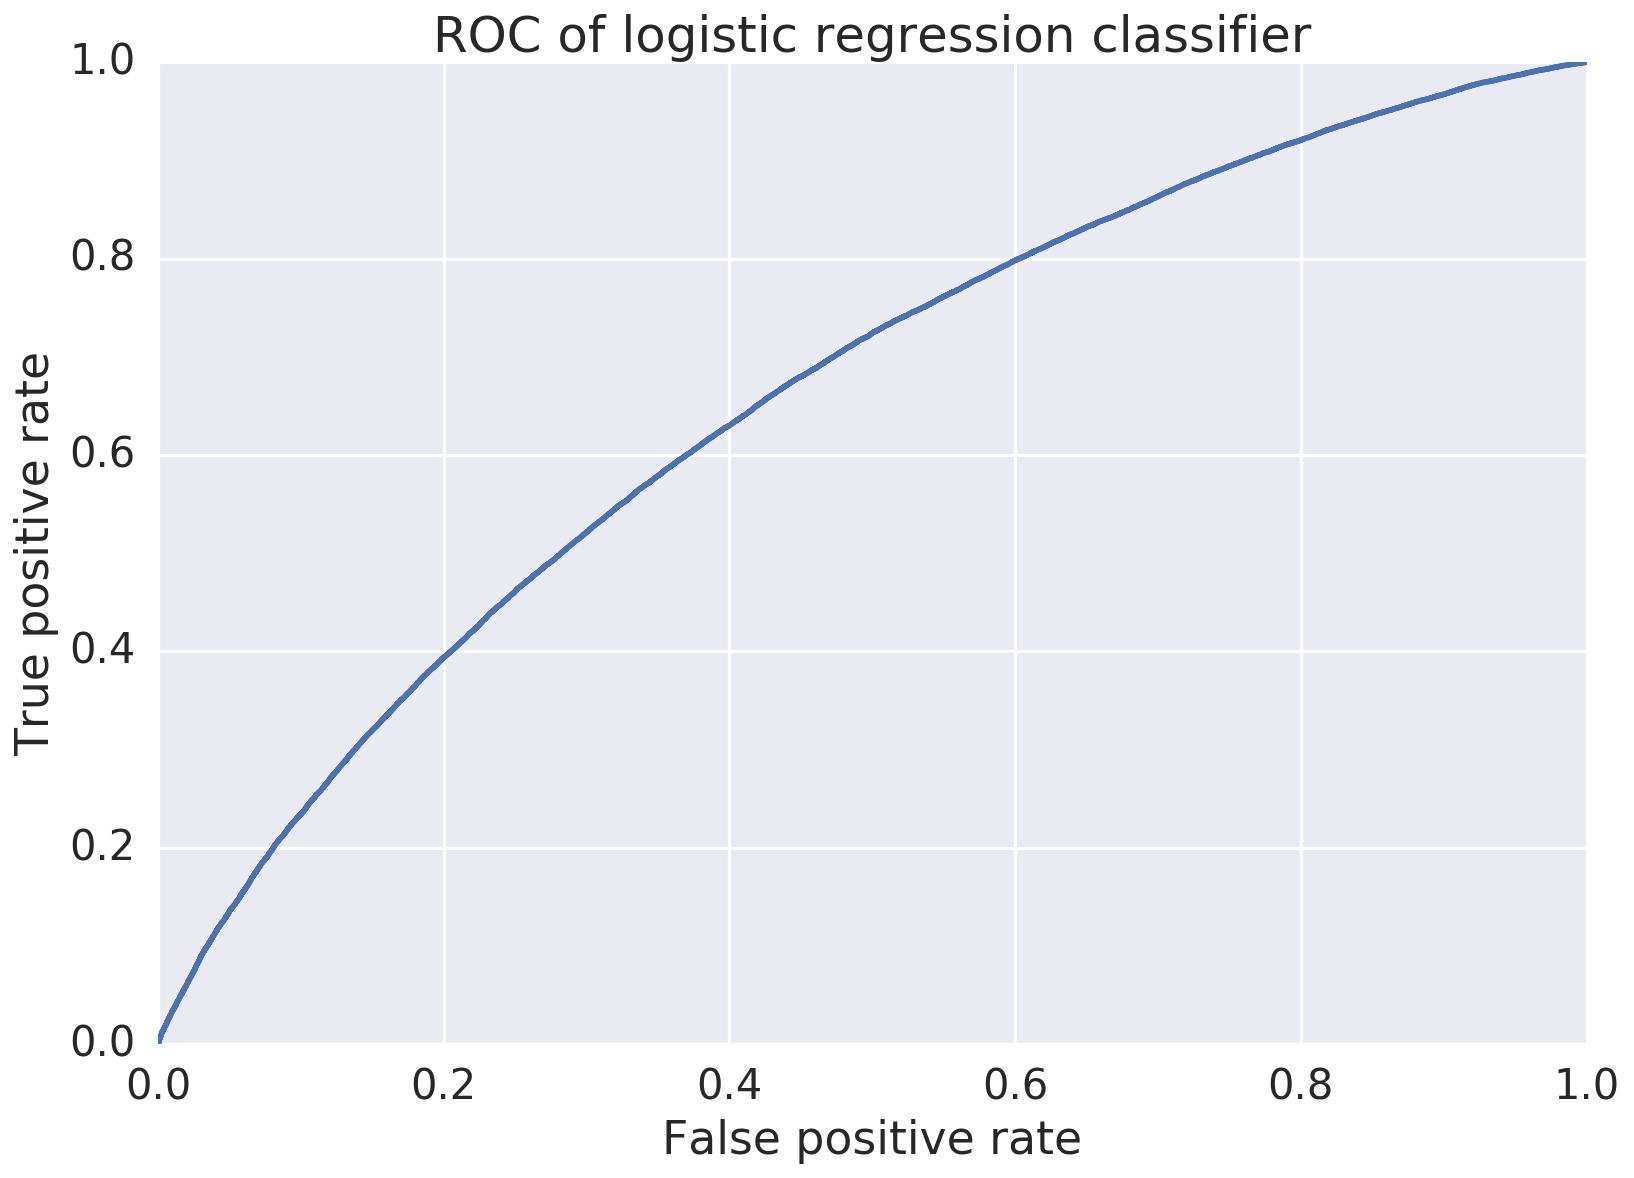

In [31]:
plt.figure()
plt.plot(fpr, tpr)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.savefig("./logistic_regression_roc.png")
plt.title("ROC of logistic regression classifier")
print("Area under curve is {}".format(metrics.auc(fpr, tpr)))

### Random Forest

In [32]:
pipeline = Pipeline(feature_union + [
#        ('to_dense', DenseTransformer()),
        ('cls', RandomForestClassifier(n_jobs=4)),
    ])
pipeline.fit(cls_train[['title', 'body', 'tags']], cls_train['success'])
y = pipeline.predict(cls_test[['title', 'body', 'tags']])
print(classification_report(y, cls_test['success']))

             precision    recall  f1-score   support

          0       0.93      0.69      0.79    109055
          1       0.12      0.44      0.19     10288

avg / total       0.86      0.67      0.74    119343



In [33]:
scores = pipeline.predict_proba(cls_test[['title', 'body', 'tags']])

In [34]:
fpr, tpr, thresholds = metrics.roc_curve(cls_test['success'], scores[:, 1], pos_label=1)

Area under curve is 0.575753927766


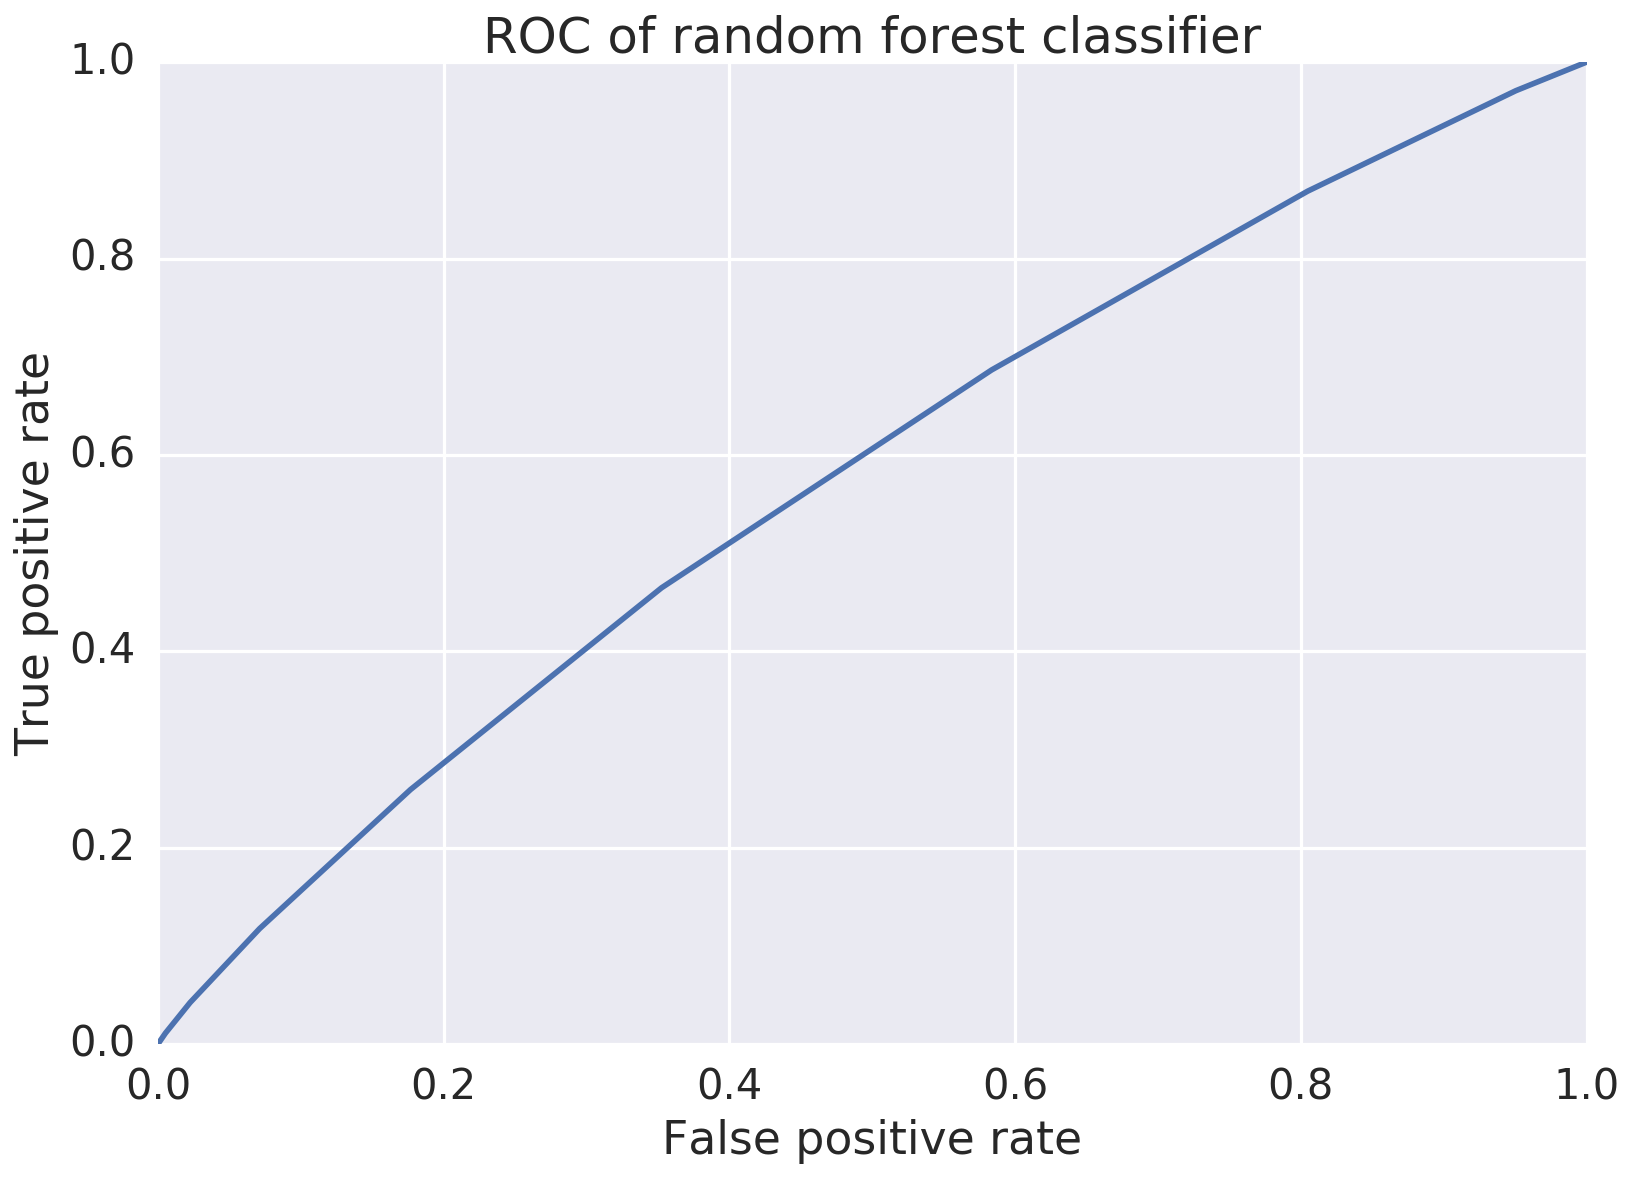

In [35]:
plt.figure()
plt.plot(fpr, tpr)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.savefig("./random_forest_roc.png")
plt.title("ROC of random forest classifier")
print("Area under curve is {}".format(metrics.auc(fpr, tpr)))

## TODO Predict when an accepted will be posted

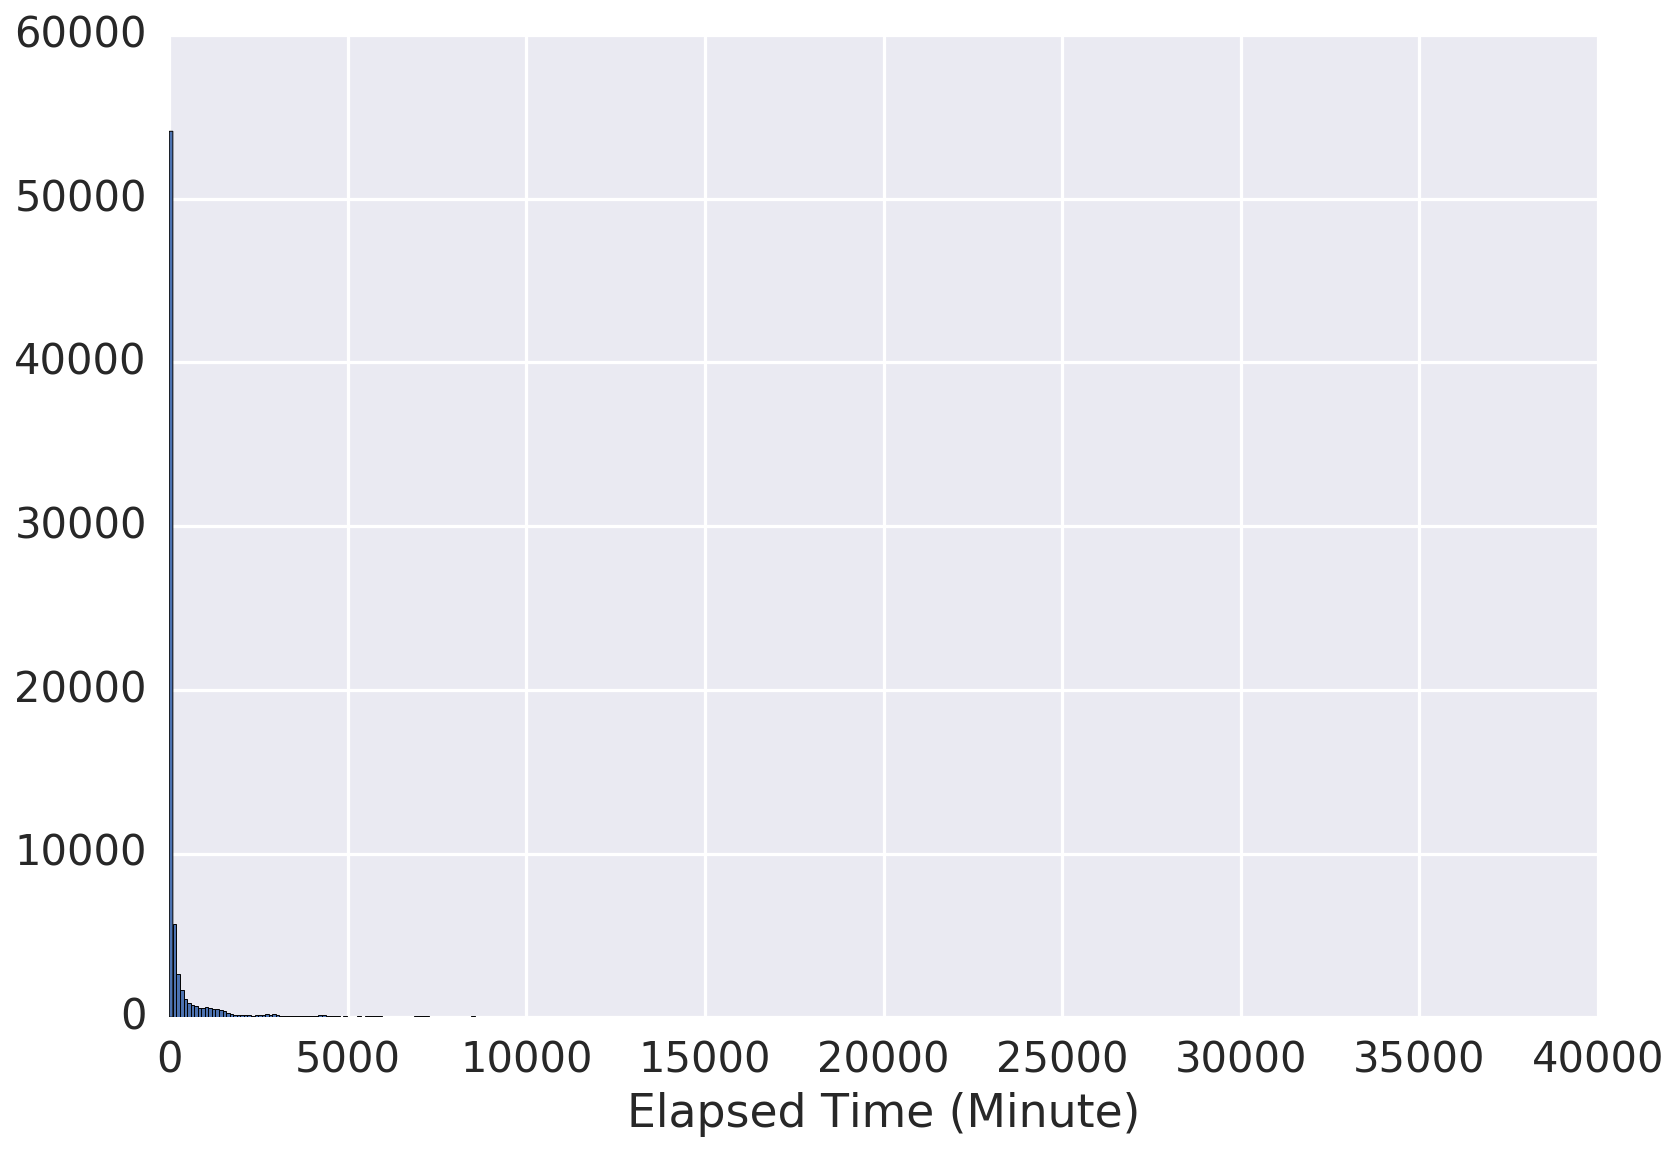

In [36]:
q_a.ElapsedTime.hist(bins=400)
plt.xlabel('Elapsed Time (Minute)')

# Votes
- Id
- PostId
- VoteTypeId (listed in the VoteTypes table)
  1. AcceptedByOriginator
  2. UpMod (AKA upvote)
  3. DownMod (AKA downvote)
  4. Offensive
  5. Favorite (UserId will also be populated)
  6. Close (since 2013-06-25 close votes are ONLY stored in the PostHistory table)
  7. Reopen
  8. BountyStart (UserId and BountyAmount will also be populated)
  9. BountyClose (BountyAmount will also be populated)
  10. Deletion
  11. Undeletion
  12. Spam
  15. ModeratorReview
  16. ApproveEditSuggestion
- UserId (only present if VoteTypeId is 5 or 8)
- CreationDate (time data is purposefully removed to protect user privacy)
- BountyAmount (only present if VoteTypeId is 8 or 9)

In [37]:
sql_query = """
SELECT * FROM votes limit 2;
"""
votes = pd.read_sql_query(sql_query, con)

In [38]:
votes

,id,postid,votetypeid,userid,creationdate,bountyamount
0,1,1,2,None,2008-07-31,None
1,2,3,2,None,2008-07-31,None


# Users

- Id
- Reputation
- CreationDate
- DisplayName
- LastAccessDate
- WebsiteUrl
- Location
- AboutMe
- Views
- UpVotes (how many upvotes the user has cast)
- DownVotes
- EmailHash (now always blank)
- AccountId (StackExchange Network profile Id of the user)
- Age

In [39]:
sql_query = """
SELECT * FROM users limit 2;
"""
users= pd.read_sql_query(sql_query, con)

In [40]:
users

,id,reputation,creationdate,displayname,lastaccessdate,websiteurl,location,aboutme,views,upvotes,downvotes,profileimageurl,age,accountid
0,-1,1,2008-07-31 00:00:00.000,Community,2008-08-26 00:16:53.810,http://meta.stackexchange.com/,on the server farm,"<p>Hi, I'm not really a person.</p>\n\n<p>I'm ...",649,143094,643540,None,NaN,-1
1,1,36925,2008-07-31 14:22:31.287,Jeff Atwood,2016-03-04 01:10:16.363,http://www.codinghorror.com/blog/,"El Cerrito, CA","<p><a href=""http://www.codinghorror.com/blog/a...",209166,3275,1300,https://www.gravatar.com/avatar/51d623f33f8b83...,46.0,1


## TODO Remove the user with id = -1

# Tags
- Id
- TagName
- Count
- ExcerptPostId
- WikiPostId

In [41]:
sql_query = """
SELECT * FROM tags limit 2;
"""
tags = pd.read_sql_query(sql_query, con)

In [42]:
tags

,id,tagname,count,excerptpostid,wikipostid
0,1,.net,227675,3624959,3607476
1,2,html,511091,3673183,3673182


# Badges
- Id
- UserId, e.g.: "420"
- Name, e.g.: "Teacher"
- Date, e.g.: "2008-09-15T08:55:03.923"
- Class
- Gold
- Silver
- Bronze
- TagBased, true if badge is for a tag, otherwise it is a named badge

In [43]:
sql_query = """
SELECT * FROM badges limit 2;
"""
badges = pd.read_sql_query(sql_query, con)

In [44]:
badges

,id,userid,name,date
0,82946,3718,Teacher,2008-09-15 08:55:03.923
1,82947,994,Teacher,2008-09-15 08:55:03.957
